In [1]:
#imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Attention, Conv1D, MaxPooling1D,
    Dropout, Flatten, RepeatVector, TimeDistributed, GaussianNoise, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
#load datasets

df_0 = pd.read_csv("Asset_0.csv")
df_11 = pd.read_csv("Asset_11.csv")


# Merge datasets
df_combined = pd.concat([df_0, df_11], ignore_index=True)


# Save combined file
df_combined.to_csv("combined_data_nndl.csv", index=False)


print("Combined dataset shape:", df_combined.shape)

df_combined

Combined dataset shape: (109240, 86)


,time_stamp,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg
0,22-05-2022 06:50,0,41807,train,0,21,85.5,-4.2,7.4,7.5,...,0,-26917,0,125146,-26917,13.5,14.8,11.4,1.0,22
1,22-05-2022 07:00,0,41808,train,0,20,87.8,6.1,7.8,7.8,...,0,-26741,0,133455,-26741,14.1,14.7,13.1,0.3,22
2,22-05-2022 07:10,0,41809,train,0,20,92.9,3.6,8.9,8.9,...,0,-28905,0,200224,-28905,14.6,14.9,13.8,0.2,22
3,22-05-2022 07:20,0,41810,train,0,20,96.9,7.5,8.8,8.8,...,0,-27062,0,196367,-27062,14.6,14.9,14.0,0.1,22
4,22-05-2022 07:30,0,41811,train,0,20,83.4,-5.9,8.6,8.5,...,0,-26566,0,176781,-26566,14.5,14.8,13.9,0.2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109235,08-06-2023 01:50,11,54707,prediction,0,23,97.8,-12.3,7.0,6.8,...,0,-19262,0,89874,-19262,13.1,14.9,11.1,1.1,23
109236,08-06-2023 02:00,11,54708,prediction,0,23,123.1,12.9,5.9,5.8,...,0,-16961,0,51700,-16961,11.9,13.5,10.9,0.6,23
109237,08-06-2023 02:10,11,54709,prediction,0,23,112.0,1.8,6.5,6.3,...,0,-17394,0,70296,-17394,12.6,14.2,11.0,0.8,23
109238,08-06-2023 02:20,11,54710,prediction,0,23,108.7,-1.5,5.0,4.8,...,0,-14145,0,28987,-14145,11.5,13.5,10.9,0.7,23


In [3]:
#DATA PREPROCESSING

# Helper functions for preprocessing and sequence-building

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (10, 5)

META_COLS = ['time_stamp', 'asset_id', 'id', 'train_test']
TARGET_COL = 'status_type_id'

# select only numeric features
# excluding metadata columns and the target label
def numeric_feature_cols(df: pd.DataFrame) -> List[str]:
    cols = []
    for c in df.columns:
        if c in META_COLS or c == TARGET_COL:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            cols.append(c)
    return cols

#missing value imputation (forward and backward fill)
def robust_fillna_per_asset(df: pd.DataFrame, feature_cols: List[str]) -> pd.DataFrame:
    if 'asset_id' in df.columns:
        df[feature_cols] = (df.groupby('asset_id')[feature_cols]
                              .apply(lambda g: g.ffill().bfill())
                              .reset_index(level=0, drop=True))
    else:
        df[feature_cols] = df[feature_cols].ffill().bfill()
    return df

# clip outliers
#uses percentile-based clipping
def clip_outliers(df: pd.DataFrame, feature_cols: List[str], lower_q=0.005, upper_q=0.995) -> pd.DataFrame:
    for c in feature_cols:
        s = df[c].astype(float)
        lo = s.quantile(lower_q)
        hi = s.quantile(upper_q)
        df[c] = s.clip(lo, hi)
    return df

#FEATURE ENGINEERING (DIFFERENCE + ROLLING MEAN)
def add_engineered_features(df: pd.DataFrame, feature_cols: List[str]) -> Tuple[pd.DataFrame, List[str]]:

    # Adds first difference and rolling-3 mean per asset

    new_cols = []

    #asset-specific processing
    if 'asset_id' in df.columns:
        grp = df.groupby('asset_id')
        for c in feature_cols:
            d1 = f'd1_{c}'
            r3 = f'r3m_{c}'
            df[d1] = grp[c].diff().fillna(0.0)
            df[r3] = grp[c].transform(lambda s: s.rolling(3, min_periods=1).mean())
            new_cols += [d1, r3]

    # no asset separation available
    else:
        for c in feature_cols:
            d1 = f'd1_{c}'
            r3 = f'r3m_{c}'
            df[d1] = df[c].diff().fillna(0.0)
            df[r3] = df[c].rolling(3, min_periods=1).mean()
            new_cols += [d1, r3]

    # Combine original + engineered features
    all_features = feature_cols + new_cols
    return df, all_features


# standard scaling
def scale_features(df: pd.DataFrame, feature_cols: List[str]) -> Tuple[np.ndarray, StandardScaler]:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols].astype(float).values)
    return X, scaler


#LSTM SEQUENCE GENERATION
#Build sliding windows per asset so windows don't cross asset boundaries.

def build_sequences_asset_safe(X: np.ndarray, y: np.ndarray, asset_ids: np.ndarray, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:

    #Label each window as 1 if ANY row in the window has status_type_id > 0, else 0.

    X_seqs, y_seqs = [], []

    # No asset_id grouping -> single global sequence
    if asset_ids is None:
        idx = np.arange(len(y))
        for i in range(0, len(idx) - seq_len + 1):
            sl = idx[i:i+seq_len]
            X_seqs.append(X[sl, :])
            y_seqs.append(int(np.max(y[sl]) > 0))

    # Build sequences separately for every asset
    else:
        for aid in pd.unique(asset_ids):
            mask = (asset_ids == aid)
            idx = np.where(mask)[0]

            for i in range(0, len(idx) - seq_len + 1):
                sl = idx[i:i+seq_len]
                X_seqs.append(X[sl, :])
                y_seqs.append(int(np.max(y[sl]) > 0))

    # Convert to numpy arrays
    X_seqs = np.stack(X_seqs, axis=0) if len(X_seqs) else np.empty((0, seq_len, X.shape[1]))
    y_seqs = np.array(y_seqs, dtype=int)
    return X_seqs, y_seqs


In [4]:
# PREPROCESSINF PIPELINE

# 1. ensuring df_combined exists
assert 'df_combined' in globals() or 'df_combined' in locals(), "df_combined not found. Assign your combined dataset to df_combined."


# 2. Sort by aasset_id and time_stamp

if 'asset_id' in df_combined.columns and 'time_stamp' in df_combined.columns:
    try:
        # Convert timestamp to proper datetime format
        df_combined['time_stamp'] = pd.to_datetime(df_combined['time_stamp'])
        df_combined = df_combined.sort_values(['asset_id', 'time_stamp']).reset_index(drop=True)

    except Exception:
        # to avoid breaking the pipeline if timestamp column has invalid formats,
        df_combined = df_combined.reset_index(drop=True)
else:
    # If one of the columns is missing, ensure clean index
    df_combined = df_combined.reset_index(drop=True)


# 3. Drop rows with missing target
df_combined = df_combined[df_combined[TARGET_COL].notna()].reset_index(drop=True)


# 4. Select numeric features. Exclude metadata
base_feature_cols = numeric_feature_cols(df_combined)
print("Initial numeric features count:", len(base_feature_cols))


# 5. Fill NaNs per asset and clip outliers
df_combined = robust_fillna_per_asset(df_combined, base_feature_cols)
df_combined = clip_outliers(df_combined, base_feature_cols, lower_q=0.005, upper_q=0.995)

# 6. Feature engineering (d1, rolling3)
df_combined, feature_cols = add_engineered_features(df_combined, base_feature_cols)
print("Final feature count after engineering:", len(feature_cols))

# 7. Scaling
X_all, scaler = scale_features(df_combined, feature_cols)

# Prepare the target variable
y_all = df_combined[TARGET_COL].astype(int).values

# extract asset IDs (if present) for per-asset sequence building
asset_ids = df_combined['asset_id'].values if 'asset_id' in df_combined.columns else None

print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


/tmp/ipython-input-1758747193.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_combined['time_stamp'] = pd.to_datetime(df_combined['time_stamp'])


Initial numeric features count: 81


/tmp/ipython-input-2226473069.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[d1] = grp[c].diff().fillna(0.0)
/tmp/ipython-input-2226473069.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[r3] = grp[c].transform(lambda s: s.rolling(3, min_periods=1).mean())
/tmp/ipython-input-2226473069.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

Final feature count after engineering: 243
X_all shape: (109240, 243) y_all shape: (109240,)


In [5]:
# Create sequences

SEQUENCE_LENGTH = 10

# Build sliding windows per asset without crossing boundaries
X_seq, y_seq = build_sequences_asset_safe(X_all, y_all, asset_ids, SEQUENCE_LENGTH)

print("Sequence dataset shape:", X_seq.shape, y_seq.shape)
print("Sequence-level positive (fault) rate:", y_seq.mean())

#Define split proportions
test_size = 0.2
val_size = 0.2

# Check class distribution (0 = normal, 1 = fault)
unique, counts = np.unique(y_seq, return_counts=True)
print("Sequence label distribution:", dict(zip(unique, counts)))


"""
If enough positives exist, use stratified splitting
Otherwise → fallback to random split

"""
if len(counts) > 1 and np.min(counts) >= 5:
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        X_seq,
        y_seq,
        test_size=test_size,
        random_state=RANDOM_STATE,
        stratify=y_seq
    )

    # Now split remaining into train pool & validation
    X_train_pool, X_val_mixed, y_train_pool, y_val_mixed = train_test_split(
        X_tmp,
        y_tmp,
        test_size=val_size,
        random_state=RANDOM_STATE,
        stratify=y_tmp

    )

else:
    # fallback to random splits if not enough positives for stratify
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        X_seq,
        y_seq,
        test_size=test_size,
        random_state=RANDOM_STATE
    )

    X_train_pool, X_val_mixed, y_train_pool, y_val_mixed = train_test_split(
        X_tmp,
        y_tmp,
        test_size=val_size,
        random_state=RANDOM_STATE
    )


# Training on normal windows only
X_train_norm = X_train_pool[y_train_pool == 0]
X_val_norm = X_val_mixed[y_val_mixed == 0]


# If no normals in val_norm, carve out 10% from train_norm
if len(X_val_norm) == 0 and len(X_train_norm) > 10:
    split = int(0.9 * len(X_train_norm))
    X_val_norm = X_train_norm[split:]
    X_train_norm = X_train_norm[:split]

print("Train normals:", X_train_norm.shape,
      "Val normals:", X_val_norm.shape,
      "Test (mixed):", X_test.shape)


Sequence dataset shape: (109222, 10, 243) (109222,)
Sequence-level positive (fault) rate: 0.4076925894050649
Sequence label distribution: {np.int64(0): np.int64(64693), np.int64(1): np.int64(44529)}
Train normals: (41403, 10, 243) Val normals: (10351, 10, 243) Test (mixed): (21845, 10, 243)


In [6]:
#Build the CNN + LSTM + Attention Autoencoder for time-series

"""
    A hybrid autoencoder combining:
      - Gaussian noise (robustness to sensor noise)
      - 1D CNN (local trend extraction)
      - LSTM encoder (temporal modeling)
      - Attention (focus on important timesteps)
      - Dense bottleneck (compressed representation)
      - LSTM decoder + TimeDistributed Dense (reconstruction)
    """

def build_cnn_lstm_attention_autoencoder(seq_len: int, n_features: int,
                                         conv_filters: int = 64,
                                         lstm_units: int = 128,
                                         dense_units: int = 64,
                                         dropout_rate: float = 0.1,
                                         gaussian_noise_std: float = 0.01) -> Model:

  # input layer
  inp = Input(shape=(seq_len, n_features), name='input')

  # Add Gaussian Noise
  x = GaussianNoise(gaussian_noise_std)(inp)

  # 1D Convolution for local pattern extraction
  x = Conv1D(filters=conv_filters, kernel_size=2,
               activation='relu', padding='same',
               name='conv1d')(x)

  # Stabilizes learning
  x = BatchNormalization()(x)

  # Downsample by factor 2 (temporal compression)
  x = MaxPooling1D(pool_size=2, name='maxpool')(x)

  # LSTM Encoder
  x = LSTM(units=lstm_units, activation='relu',
             return_sequences=True, name='lstm_enc')(x)

  # Attention mechanism
  att = Attention(name='attention')([x, x])

  # Flatten + Dense bottleneck
  flat = Flatten(name='flatten')(att)
  dense = Dense(dense_units, activation='relu',
                name='bottleneck_dense')(flat)

  # Mild dropout for regularization
  drop = Dropout(dropout_rate)(dense)

  # Repeat latent vector to match sequence length
  rep = RepeatVector(seq_len)(drop)

  # LSTM Decoder
  dec = LSTM(units=lstm_units, activation='relu',
               return_sequences=True, name='lstm_dec')(rep)

  # TimeDistributed Dense layer
  out = TimeDistributed(
      Dense(n_features, activation='linear'),
      name='reconstruction'
  )(dec)


  # Compile model
  model = Model(inp, out, name='cnn_lstm_attention_autoencoder')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss='mse'   # reconstruction loss
  )

  return model


# Instantiate the model using actual sequence dims
seq_len, n_features = X_seq.shape[1], X_seq.shape[2]

model = build_cnn_lstm_attention_autoencoder(
    seq_len, n_features,
    conv_filters=64,
    lstm_units=128,
    dense_units=64,
    dropout_rate=0.1,
    gaussian_noise_std=0.01
)

# Print architecture summary
model.summary()

Model: "cnn_lstm_attention_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 10, 243)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 10, 243)   │          0 │ input[0][0]       │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │     31,168 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool             │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_enc (LSTM)     │ (None, 5, 128)    │     98,816 │ maxpool[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 128)    │          0 │ lstm_enc[0][0],   │
│ (Attention)         │                   │            │ lstm_enc[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 640)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_dense    │ (None, 64)        │     41,024 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bottleneck_dense… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 10, 64)    │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dec (LSTM)     │ (None, 10, 128)   │     98,816 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 10, 243)   │     31,347 │ lstm_dec[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 301,427 (1.15 MB)

 Trainable params: 301,299 (1.15 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5399
Epoch 1: val_loss improved from inf to 0.34882, saving model to best_autoencoder.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.5393 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 2/50
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3488
Epoch 2: val_loss improved from 0.34882 to 0.31826, saving model to best_autoencoder.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3487 - val_loss: 0.3183 - learning_rate: 0.0010
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3248
Epoch 3: val_loss improved from 0.31826 to 0.29901, saving model to best_autoencoder.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3248 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 4/50
158/162 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3073
Epoch 4: val_loss improved from 0.29901 to 0.28555, saving model to best_autoencoder.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3071 - val_loss: 0.2

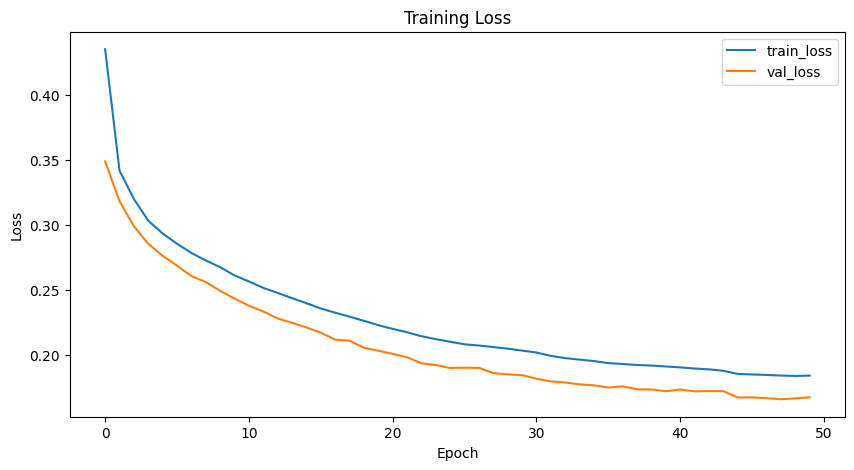

In [7]:
# TRAINING THE AUTOENCODER

# Define training hyperparameters
EPOCHS = 50
BATCH_SIZE = 256


#Callbacks to stabilize training
callbacks = [
    # Stop training early if validation loss does not improve for 8 epochs
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                      min_lr=1e-6, verbose=1),

    # Save the best model weights (based on validation loss)
    ModelCheckpoint('best_autoencoder.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]


# Model Training
history = model.fit(
    X_train_norm,          # input sequences
    X_train_norm,          # target sequences (same as input)
    validation_data=(X_val_norm, X_val_norm),   # validation on normal sequences
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


#Plot Training Curve

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [8]:
# Reconstruction Error & Thresholding

# Compute per-sequence MSE between true and reconstructed sequences
def mse_per_sequence(X_true: np.ndarray, X_pred: np.ndarray) -> np.ndarray:
    return np.mean(np.square(X_true - X_pred), axis=(1, 2))



# Generate reconstructions for train, validation, and test sets
train_recon = model.predict(X_train_norm, verbose=0)
val_recon   = model.predict(X_val_mixed, verbose=0)
test_recon  = model.predict(X_test, verbose=0)


# Compute MSE-based anomaly scores
train_mse = mse_per_sequence(X_train_norm, train_recon)
val_mse   = mse_per_sequence(X_val_mixed, val_recon)
test_mse  = mse_per_sequence(X_test, test_recon)


#Unsupervised Threshold

thr_unsup = float(np.percentile(train_mse, 99))
print("Unsupervised (99th percentile) threshold:", thr_unsup)

#Supervised Threshold Tuning (Validation Set)

def best_threshold_by_f1(y_true, scores, low_q=0.80, high_q=0.999, n_candidates=200):

    # Search threshold values between given quantiles of the score to maximize the F1 score.

    thr_candidates = np.quantile(scores, np.linspace(low_q, high_q, n_candidates))

    best_f1 = -1.0
    best_thr = thr_candidates[0]
    best_metrics = None

    for t in thr_candidates:
        y_pred = (scores > t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_thr = t
            best_metrics = {'precision': p, 'recall': r, 'f1': f1}

    return best_thr, best_metrics


# Apply F1-based tuning only when validation contains both classes
if len(np.unique(y_val_mixed)) > 1:
    thr_f1, f1_metrics = best_threshold_by_f1(y_val_mixed, val_mse)
    print("F1-tuned threshold:", thr_f1, "Val metrics:", f1_metrics)
else:
    # If validation has no positives, fallback to unsupervised threshold
    thr_f1, f1_metrics = thr_unsup, {'f1': None}
    print("No positive samples in val_mixed; using unsupervised threshold.")


#Choose Best Threshold (Supervised vs Unsupervised)

if f1_metrics['f1'] is not None:
    # Compute F1 for unsupervised threshold and compare
    y_val_unsup = (val_mse > thr_unsup).astype(int)
    p_u, r_u, f1_u, _ = precision_recall_fscore_support(
        y_val_mixed, y_val_unsup, average='binary', zero_division=0
    )

    chosen_thr = thr_f1 if f1_metrics['f1'] >= f1_u else thr_unsup
else:
    chosen_thr = thr_unsup

print("Chosen threshold:", chosen_thr)


# Final Test Evaluation

# Predict anomalies using chosen threshold
y_test_pred = (test_mse > chosen_thr).astype(int)
y_test_true = y_test.astype(int)

print("\nTest confusion matrix:")
print(confusion_matrix(y_test_true, y_test_pred))

print("\nTest classification report:")
print(classification_report(y_test_true, y_test_pred, zero_division=0))

# Evaluate how well the MSE anomaly score separates classes
try:
    auc_score = roc_auc_score(y_test_true, test_mse)
    print("AUC (anomaly score):", auc_score)
except Exception:
    pass

Unsupervised (99th percentile) threshold: 0.4724752518938516
F1-tuned threshold: 0.32275403496277805 Val metrics: {'precision': 0.8755364806866953, 'recall': 0.42947368421052634, 'f1': 0.576271186440678}
Chosen threshold: 0.32275403496277805

Test confusion matrix:
[[12428   511]
 [ 5099  3807]]

Test classification report:
              precision    recall  f1-score   support

           0       0.71      0.96      0.82     12939
           1       0.88      0.43      0.58      8906

    accuracy                           0.74     21845
   macro avg       0.80      0.69      0.70     21845
weighted avg       0.78      0.74      0.72     21845

AUC (anomaly score): 0.7790873539917227


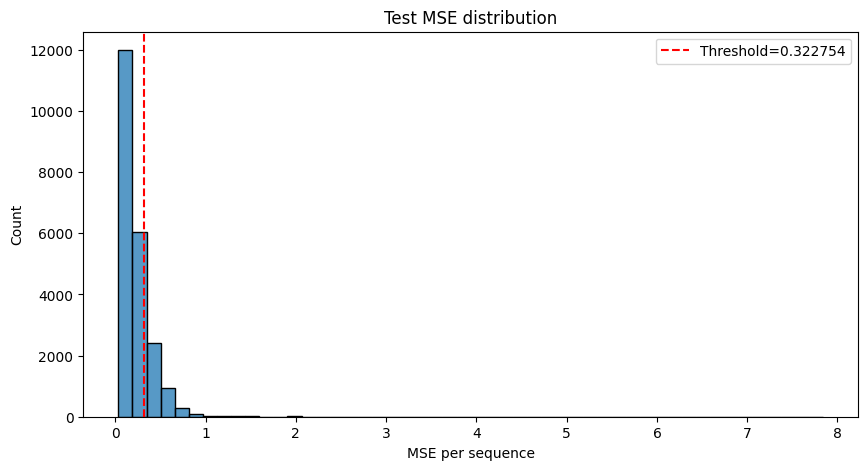

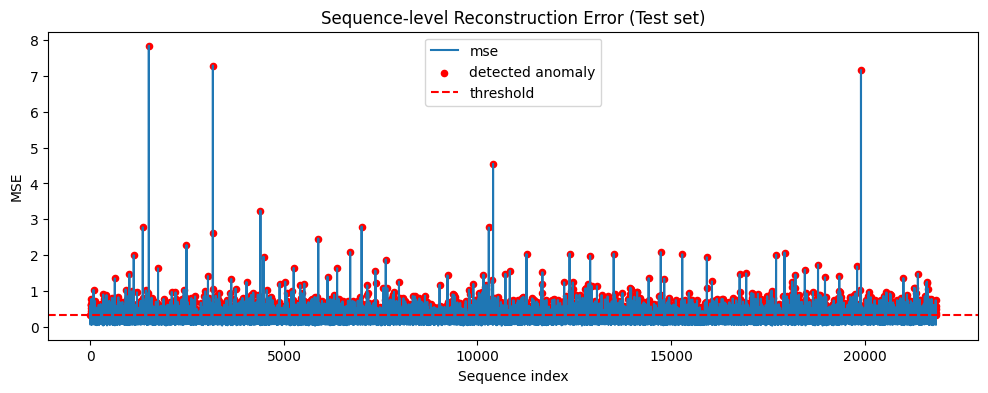

Artifacts saved to outputs_wind_fault/


In [9]:
# Plots
# distribution of test MSE
plt.figure()
sns.histplot(test_mse, bins=50, kde=False)
plt.axvline(chosen_thr, color='r', linestyle='--', label=f'Threshold={chosen_thr:.6f}')
plt.title("Test MSE distribution")
plt.xlabel("MSE per sequence"); plt.legend(); plt.show()

# timeline of test MSE (sequence index)
plt.figure(figsize=(12,4))
plt.plot(test_mse, label='mse')
anoms = np.where(test_mse > chosen_thr)[0]
plt.scatter(anoms, test_mse[anoms], color='r', label='detected anomaly', s=20)
plt.axhline(chosen_thr, color='r', linestyle='--', label='threshold')
plt.title('Sequence-level Reconstruction Error (Test set)')
plt.xlabel('Sequence index'); plt.ylabel('MSE'); plt.legend(); plt.show()

# Save model & artifacts
os.makedirs('outputs_wind_fault', exist_ok=True)
model.save('outputs_wind_fault/cnn_lstm_attention_autoencoder.keras')
np.save('outputs_wind_fault/train_mse.npy', train_mse)
np.save('outputs_wind_fault/val_mse.npy', val_mse)
np.save('outputs_wind_fault/test_mse.npy', test_mse)
pd.DataFrame({'reconstruction_error': test_mse, 'true_class': y_test_true}).to_csv('outputs_wind_fault/test_reconstruction_errors.csv', index=False)
with open('outputs_wind_fault/threshold.txt', 'w') as f:
    f.write(str(chosen_thr))
print("Artifacts saved to outputs_wind_fault/")
